# Introduction
***
# 🚀 Spaceship Titanic: A Machine Learning Journey 🚢

Welcome aboard the Spaceship Titanic! In this notebook, we will explore the dataset of passengers who were transported to an alternate dimension when the Titanic spaceship collided. 

> Our goal is to predict which passengers would have survived this catastrophic event using machine learning techniques.

We will be using scikit-learn pipelines, one-hot and label encoders, quantile transformer, PCA for great 3D visualization, hyperopt for hyperparameter tuning and CatBoostClassifier.

> With an accuracy score of **81.2%**, this notebook ranked in the **top 7%** of all participants.

Join me on this journey as we uncover insights and patterns that will help us understand what it takes to survive a spaceship collision.

## We will go through

- Creating easy to use **data processing pipelines** using scikit-learn
- Applying standard scaler and **quantile transformer** to normalize the data and reduce outliers
- Using PCA to reduce dimensionality and create **stunning 3D plots**
- Optimizing the model hyperparameters using **hyperopt**
- Evaluating the model performance using accuracy, F1 score and confusion matrix
- Interpreting the model results using feature importance and **SHAP values**


# Libraries
***

In [1]:
# Holy grail
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Hyperparameter optimization library
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Machine learning model
from catboost import CatBoostClassifier, Pool

# Model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost.utils import get_confusion_matrix

# SHAP values
import shap

# Random state
RS = 2137

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Load data
***

In [2]:
train = pd.read_csv('../input/spaceship-titanic/train.csv', index_col='PassengerId')
train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Data analysis
***

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 891.4+ KB


In [4]:
# Number of missing values in each column
train.isnull().sum()

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

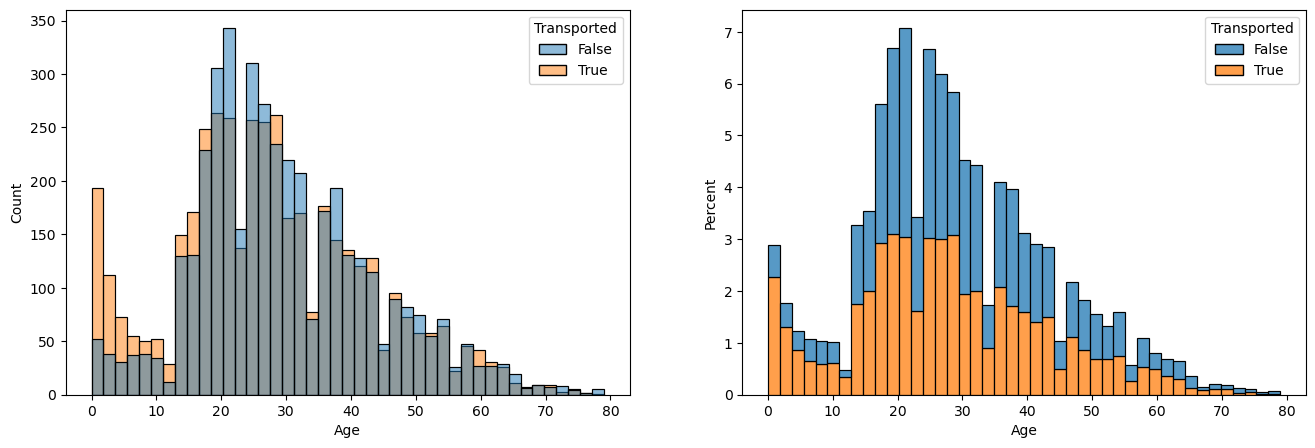

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(data=train, x='Age', hue='Transported', ax=ax[0])
sns.histplot(data=train, x='Age', hue='Transported', stat='percent', multiple='stack', ax=ax[1])
plt.show()

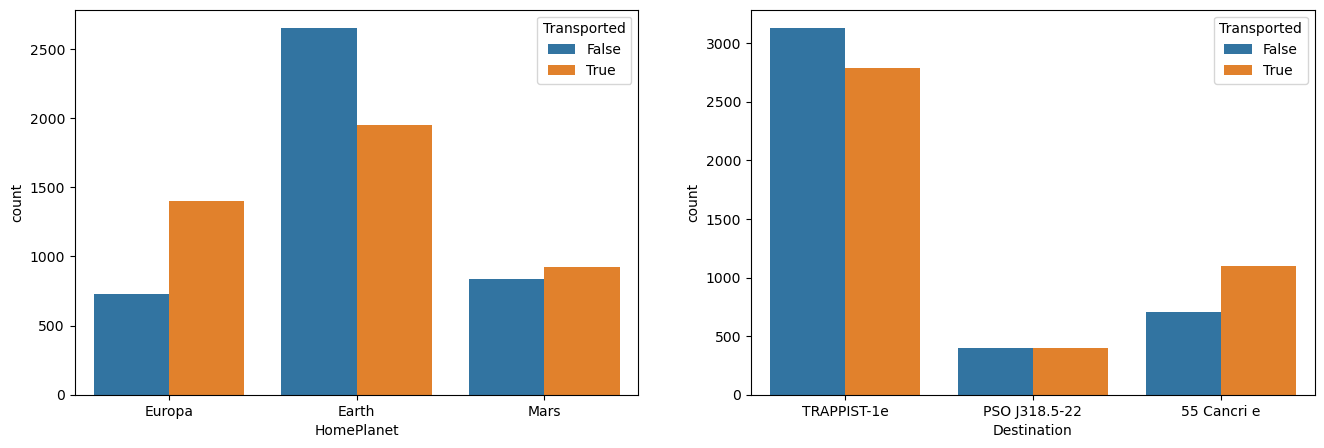

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(data=train, x='HomePlanet', hue='Transported', ax=ax[0])
sns.countplot(data=train, x='Destination', hue='Transported', ax=ax[1])
plt.show()

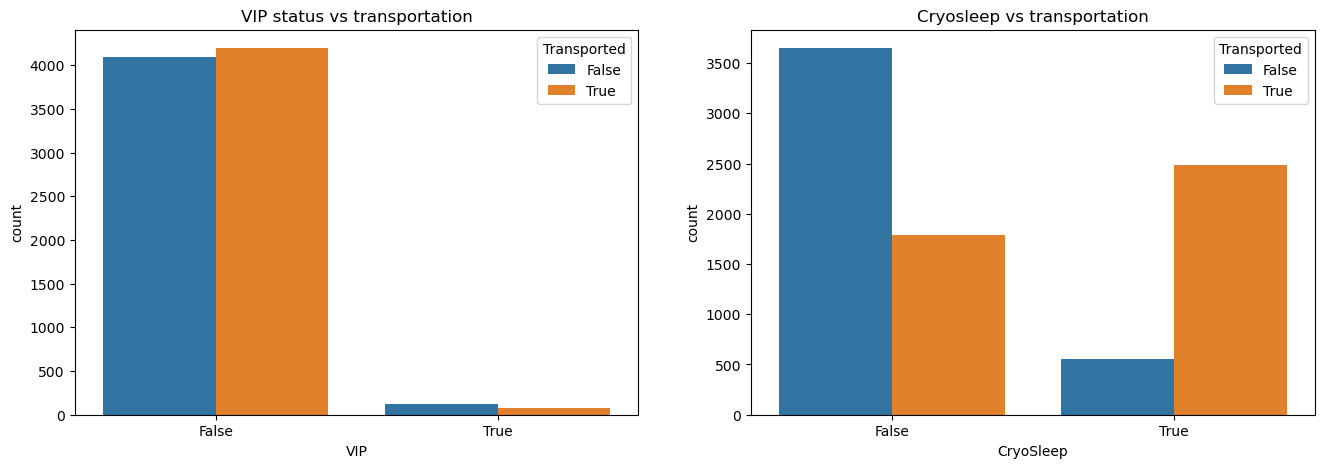

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

sns.countplot(data=train, x='VIP', hue='Transported', ax=ax[0])
sns.countplot(data=train, x='CryoSleep', hue='Transported', ax=ax[1])

ax[0].set_title('VIP status vs transportation')
ax[1].set_title('Cryosleep vs transportation')

plt.show()

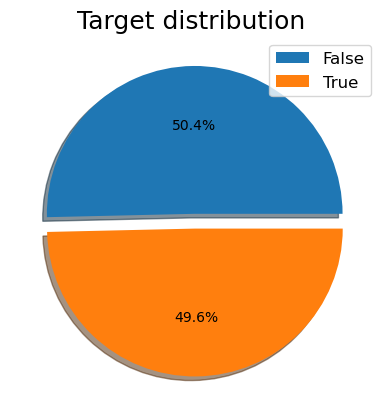

In [8]:
plt.pie(train['Transported'].value_counts(), shadow=True, explode=[.05,.05], autopct='%.1f%%')
plt.title('Target distribution ', size=18)
plt.legend(['False', 'True'], loc='best', fontsize=12)
plt.show()

# Feature engineering
***

## Name
**Create `Surname` column by splitting `Name`.**

In [9]:
train['Surname'] = train.loc[train['Name'].notnull(), 'Name'].apply(lambda x: x.split()[1])

## Room number
**First part of passenger's id can tell us his room number.** Room number will propably help us with missing cabins, surnames, destination and home planets.

In [10]:
train['RoomNumber'] = train.index.str.split('_').str[0].astype(int)

## Investigating columns corelated with room number
Let's see which column's missing values can `RoomNumber` help us with. 

In [11]:
# Analysis of passengers in each cabin
train[['Cabin', 'RoomNumber', 'Name', 'HomePlanet', 'Destination', 'VIP', 'CryoSleep']].value_counts().head(40)

Cabin    RoomNumber  Name               HomePlanet  Destination    VIP    CryoSleep
A/0/P    119         Kleeiak Coning     Europa      TRAPPIST-1e    False  True         1
F/856/P  4172        Peefox Flell       Mars        TRAPPIST-1e    False  True         1
F/86/S   470         Aptal Binie        Mars        55 Cancri e    False  True         1
F/859/P  4176        Wille Fla          Mars        55 Cancri e    False  False        1
                     Wafros Fla         Mars        TRAPPIST-1e    False  True         1
                     Shood Opité        Mars        TRAPPIST-1e    False  False        1
                     Rants Fla          Mars        TRAPPIST-1e    False  True         1
                     Othawk Fla         Mars        TRAPPIST-1e    False  False        1
                     Lidex Opité        Mars        TRAPPIST-1e    False  True         1
F/858/P  4175        Thery Burnerez     Earth       55 Cancri e    False  False        1
F/857/S  4574        Cank 

In [12]:
# Analysis of passengers in each room
train[['RoomNumber', 'Cabin', 'Name', 'HomePlanet', 'Destination', 'VIP', 'CryoSleep']].value_counts().head(40)

RoomNumber  Cabin     Name                HomePlanet  Destination    VIP    CryoSleep
1           B/0/P     Maham Ofracculy     Europa      TRAPPIST-1e    False  False        1
6137        G/994/S   Race Serry          Earth       TRAPPIST-1e    False  False        1
6148        F/1176/S  Pikes Sueke         Mars        TRAPPIST-1e    False  True         1
                      Jagice Sueke        Mars        TRAPPIST-1e    False  True         1
6146        B/207/P   Scelava Groforacid  Europa      TRAPPIST-1e    False  False        1
6143        F/1175/S  Willah Browlerson   Earth       TRAPPIST-1e    False  False        1
6141        F/1174/S  Natald Haydenzier   Earth       PSO J318.5-22  False  False        1
6139        C/230/S   Sinon Reedall       Europa      55 Cancri e    False  True         1
                      Pleions Reedall     Europa      TRAPPIST-1e    False  False        1
                      Jabba Reedall       Europa      TRAPPIST-1e    False  True         1
    


<div class="warning" style="background-color: #DDE6ED; border-left: 6px solid #27374D; font-size: 100%; padding: 10px;">
    <h3 style="color: #27374D; font-size: 18px; margin-top: 0; margin-bottom: 10px;">🔎  Observations:</h3>
    <ol>
        <li>Passengers in the same <i>Cabin</i> have the same <i>RoomNumber</i>.</li>
        <li>Passengers with the same <i>RoomNumber</i> rarely don't have the same <i>Cabin</i> (see <i>RoomNumber</i> 6137 above).</li>
        <li>Passengers in the same <i>Cabin</i>/RoomNumber most likely have the same <i>Surname</i>, <i>HomePlanet</i> and <i>Destination</i></li>
        <li>There is no correlation between <i>Cabin</i>/<i>RoomNumber</i> and <i>VIP</i>, <i>CryoSleep</i></li>
    </ol>
</div>
<br></br>
<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>Note :</b> For simplicity let's assume that one <i>RoomNumber</i> directly corresponds to one <i>Cabin</i> (it rarely isn't the case so it won't affect model performance by much). We have <i>RoomNumber</i> for every passenger so we will use it to fill missing values for <i>Cabin</i>, <i>Surname</i>, <i>HomePlanet</i> and <i>Destination</i>. Cabin would be a bit better because it has higher corelation with abovementioned columns but there are too many missing values in it.
</div>

### Filling missing values 
First let's fill missing values of `Cabin`, `Surname`, `HomePlanet` and `Destination` based on `RoomNumber`. We will assume that passengers in one room have the same cabin, destination, surname and home planet.

In [13]:
room_related_columns = ['Cabin', 'Surname', 'Destination', 'HomePlanet']

# room_to_col is a pandas series that gives most common cabin, surname, destination or home planet for certain room number
# Series indexes are room numbers and values are cabins, surnames, etc.
# I will use this series to map passengers room number to missing values in columns
# Note: note every room number is in series due to missing values in single person rooms
# Reason for that is if only one person was in a room and it had one of the columns missing then his/hers room isn't
# in room_to_col so it won't be used to map this missing value

for col in room_related_columns:
    room_to_col = train[['RoomNumber', col]].dropna().groupby('RoomNumber')[col].apply(lambda x: x.mode()[0]) # without dropna mode for single person rooms with nan col would be empty and mode()[0] will raise an error
    train[col] = train.apply(lambda row: room_to_col[row['RoomNumber']] if pd.isna(row[col]) and row['RoomNumber'] in room_to_col.index else row[col], axis=1)
    train[col] = train.groupby('RoomNumber')[col].ffill().bfill()

## Total spent
Let's create `TotalSpent` column that sums up all the expenses

**Total spent = Age + RoomService + FoodCourt + ShoppingMall + Spa + VRDeck**

In [14]:
expense_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

train['TotalSpent'] = train[expense_columns].sum(axis=1)

# Assume that if passenger didn't spend any money in non-missing expense columns then he popably didn't in a missing columns (most often there is only 1 column missing so propability of that is high)
train.loc[train['TotalSpent'] == 0, expense_columns] = 0

## Cabin
**Split `Cabin` collumn to `CabLetter`, `CabNumber`, `CabSide`**

In [15]:
train[['CabLetter', 'CabNumber', 'CabSide']] = train['Cabin'].str.split('/', expand=True)

# After Cabin split, CabNumber is a object type column so we will convert it to int 
train['CabNumber'] = pd.to_numeric(train['CabNumber']).astype(int)

## Cryosleep
**If person was in cryosleep then they couldn't spent any money and if they spent money then they couldn't be in cryosleep.**

Let's use that observation to fill in the missing values in those columns.

In [16]:
# If passenger is in cryosleep then set his/hers expenses to 0
train.loc[train['CryoSleep']==True, ['TotalSpent'] + expense_columns] = 0
# If passegner spend any money then they couln't be in cryosleep
train.loc[train['CryoSleep'].isnull() & train['TotalSpent'] > 0, 'CryoSleep'] = False
# If passegner didn't spend any money then they are propably in cryosleep
train.loc[train['CryoSleep'].isnull() & train['TotalSpent'] == 0, 'CryoSleep'] = True

## Drop columns
Now we can drop columns from which we have extracted necessary information

In [17]:
train.drop(columns=['Cabin', 'Name'], inplace=True)

In [18]:
# Number of missing values in each column
train.isnull().sum()

HomePlanet        0
CryoSleep         0
Destination       0
Age             179
VIP             203
RoomService     103
FoodCourt       102
ShoppingMall    100
Spa             112
VRDeck          102
Transported       0
Surname           0
RoomNumber        0
TotalSpent        0
CabLetter         0
CabNumber         0
CabSide           0
dtype: int64

**Missing values are now only in numerical columns**

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   object 
 2   Destination   8693 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8590 non-null   float64
 6   FoodCourt     8591 non-null   float64
 7   ShoppingMall  8593 non-null   float64
 8   Spa           8581 non-null   float64
 9   VRDeck        8591 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Surname       8693 non-null   object 
 12  RoomNumber    8693 non-null   int64  
 13  TotalSpent    8693 non-null   float64
 14  CabLetter     8693 non-null   object 
 15  CabNumber     8693 non-null   int64  
 16  CabSide       8693 non-null   object 
dtypes: bool(1), float64(7), int64(2), object(7)
memory usage: 1.4+ MB


# Data preprocessing
***

## Split
**Split `train` dataframe to `X` and `y` dataframes**

In [20]:
X = train.drop(columns=['Transported'], inplace=False)
y = train['Transported'].astype(int)

## Create a pipeline
### Numerical columns
- `StandardImputer()` fills missing values with mean
- `QuantileTransformer()` is used so the data follows normal distribution
- `StandartScaler()` normalizes the data, mean = 0, std = 1

### Categorical columns
- `StandardImputer()` fills missing values with most frequent ones
- `OneHotEncoder()` one-hot encodes the data
- Categorical one-hot encoded columns are already binary so performing `QuantileTransformer()` and `StandartScaler()` won't change much

**`Surname` column is categorical but label encoded (not binary) so transformers from numerical columns should be used on it**

In [21]:
numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    QuantileTransformer(output_distribution='normal', random_state=RS),
    StandardScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', drop='first')
)

column_transformer = make_column_transformer(
    # Numerical Columns
    (
        numerical_pipeline,
        make_column_selector(dtype_include=['float64', 'int64'])
    ),
    # Categorical columns
    (
        categorical_pipeline,
        ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabLetter', 'CabSide']
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1)
        ),
        ['Surname']
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [22]:
X_transformed = column_transformer.fit_transform(X)

In [23]:
column_transformer.get_feature_names_out().tolist()

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'RoomNumber',
 'TotalSpent',
 'CabNumber',
 'HomePlanet_Europa',
 'HomePlanet_Mars',
 'Destination_PSO J318.5-22',
 'Destination_TRAPPIST-1e',
 'VIP_True',
 'CabLetter_B',
 'CabLetter_C',
 'CabLetter_D',
 'CabLetter_E',
 'CabLetter_F',
 'CabLetter_G',
 'CabLetter_T',
 'CabSide_S',
 'Surname']

In [24]:
X_transformed = pd.DataFrame(data=X_transformed, columns=column_transformer.get_feature_names_out().tolist())
X_transformed.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,RoomNumber,TotalSpent,CabNumber,HomePlanet_Europa,...,VIP_True,CabLetter_B,CabLetter_C,CabLetter_D,CabLetter_E,CabLetter_F,CabLetter_G,CabLetter_T,CabSide_S,Surname
0,0.687314,-0.728833,-0.750479,-0.721543,-0.776926,-0.742384,-5.184648,-1.158301,-5.099170,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1431.0
1,-0.161416,1.251290,1.134122,1.231545,1.309369,1.201219,-3.606217,0.621619,-5.099170,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2109.0
2,1.549540,1.218752,1.569770,-0.721543,1.765332,1.204310,-3.423109,1.309495,-5.099170,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1990.0
3,0.401203,-0.728833,1.426241,1.383480,1.598274,1.266890,-3.423109,1.113858,-5.099170,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1990.0
4,-0.814420,1.319495,1.188760,1.309119,1.314234,1.123672,-3.311901,0.782533,-2.692718,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1778.0


In [25]:
X_transformed.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,RoomNumber,TotalSpent,CabNumber,HomePlanet_Europa,...,VIP_True,CabLetter_B,CabLetter_C,CabLetter_D,CabLetter_E,CabLetter_F,CabLetter_G,CabLetter_T,CabSide_S,Surname
count,8.693000e+03,8.693000e+03,8.693000e+03,8.693000e+03,8.693000e+03,8.693000e+03,8.693000e+03,8.693000e+03,8.693000e+03,8693.000000,...,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,1.144323e-17,-2.325427e-16,5.067715e-17,-1.160670e-16,-1.199496e-16,-2.233473e-16,2.615595e-17,1.362970e-16,5.231190e-17,0.251467,...,0.022892,0.092258,0.088232,0.056252,0.102611,0.329345,0.300127,0.000690,0.504429,1110.275394
std,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,0.433881,...,0.149568,0.289407,0.283648,0.230421,0.303468,0.470003,0.458339,0.026264,0.500009,640.996185
min,-4.295686e+00,-7.288334e-01,-7.504789e-01,-7.215430e-01,-7.769261e-01,-7.423837e-01,-5.184648e+00,-1.158301e+00,-5.099170e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.792634e-01,-7.288334e-01,-7.504789e-01,-7.215430e-01,-7.769261e-01,-7.423837e-01,-6.729310e-01,-1.158301e+00,-6.589387e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,553.000000
50%,3.459393e-02,-7.288334e-01,-7.504789e-01,-7.215430e-01,-7.769261e-01,-7.423837e-01,2.917696e-04,6.088154e-01,3.826253e-03,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1109.000000
75%,5.877372e-01,1.228631e+00,1.197145e+00,1.238323e+00,1.162136e+00,1.208487e+00,6.718801e-01,8.397932e-01,6.655060e-01,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1648.000000
max,4.390025e+00,2.736080e+00,2.697940e+00,2.749482e+00,2.656061e+00,2.711784e+00,5.184160e+00,2.378492e+00,5.106823e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2216.000000


### After transformation:
- Every numeric column has standard deviation = 1 and mean = 0
- Categorical columns are one-hot encoded
- Missing values were filled

# Visualization
***
Using PCA, we can easily visualize the high-dimensional data in a lower-dimensional space and identify patterns and clusters that are not visible in the original data. In our case, we applied PCA to the Spaceship Titanic dataset and created **stunning 3D plots** that revealed **two main clusters** of passengers representing those who were more likely to survive and those who were less likely to survive the spaceship collision.

In [26]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_transformed)

# Create a dataframe with the PCA data and the target variable
df = pd.DataFrame({'x': X_pca[:, 0], 'y' : X_pca[:, 1], 'z' : X_pca[:, 2], 'Transported': y})

# Create a 3D scatter plot with color-coded points
fig = px.scatter_3d(df, x='x', y='y', z='z', color='Transported')

fig.show()

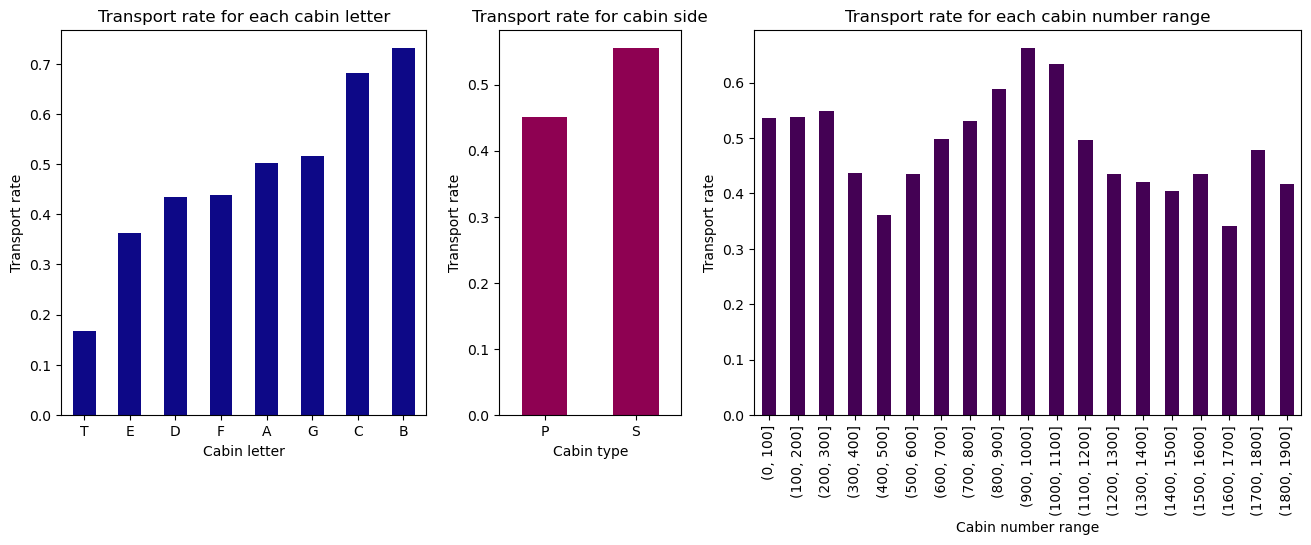

In [27]:
# This code generates three plots that show the transport rate for each cabin letter, cabin side, and cabin number range
fig, ax = plt.subplots(1, 3, figsize=(16, 5), width_ratios=[2, 1, 3])

# Cabin letter and cabin side
grouped_by_letter = train.groupby(by='CabLetter')['Transported'].apply(lambda x: x.sum() / len(x)).sort_values(ascending=True)
grouped_by_type = train.groupby(by='CabSide')['Transported'].apply(lambda x: x.sum() / len(x)).sort_values(ascending=True)

grouped_by_letter.plot(kind='bar', title='Transport rate for each cabin letter', ylabel='Transport rate', xlabel='Cabin letter', ax=ax[0], cmap='plasma')
grouped_by_type.plot(kind='bar', title='Transport rate for cabin side', ylabel='Transport rate', xlabel='Cabin type', ax=ax[1], cmap='PiYG')

ax[0].tick_params(axis='x', labelrotation=0)
ax[1].tick_params(axis='x', labelrotation=0)

# Cabin number range
bins = pd.cut(train['CabNumber'], range(0, 1901, 100))
transported_per_bin = train.groupby(bins)['Transported'].apply(lambda x: x.sum() / len(x))
transported_per_bin.plot(kind='bar', title='Transport rate for each cabin number range', ylabel='Transport rate', xlabel='Cabin number range', ax=ax[2], cmap='viridis')

plt.show()

# Modeling
***
In this almost final section we will:
1. **Split the dataset** to training and validation sets
2. **Find the best hyperparatemers** using Hyperopt
3. **Fit the CatBoostClassifier** using those hyperparapeters
4. Evaluate model using **accuracy score** and **confusion matrix**
5. Investigate model using **SHAP** values

I found `CatBoostClassifier` to work the best with our dataset. It has 2 percentage points higher accuracy than `XGBoostClassifier`.

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X_transformed, y, train_size=0.8, random_state=RS)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6954, 23) (6954,)
(1739, 23) (1739,)


In [29]:
# In space we define ranges of our hyperparameters
space = {
    'num_trees': hp.quniform('num_trees', 100, 200, 10),
    'learning_rate': hp.uniform('learning_rate', 0, 0.3),
    'depth': hp.quniform('depth', 2, 9, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'bagging_temperature': hp.uniform('bagging_temperature', 1, 10),
    'seed': 0
}

In [30]:
def objective(space):
    model = CatBoostClassifier(
        num_trees = int(space['num_trees']), # quniform returns a float with .0 floating point and num_trees must be int
        learning_rate = space['learning_rate'],
        depth = int(space['depth']),
        l2_leaf_reg = space['l2_leaf_reg'], 
        bagging_temperature = space['bagging_temperature']
    )
    
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )
    
    score = accuracy_score(y_val, model.predict(X_val))
    return {'loss': 1-score, 'status': STATUS_OK, 'model': model}

In [31]:
trials = Trials()
# I found around 500 evaluations to work the best
# < 500 doesn't find the best parameters
# > 1000 causes overfitting so the model doesn't generalize well
# best_hyperparams = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals=500, trials = trials)

In [32]:
# best_hyperparams

In [33]:
model = CatBoostClassifier(
    num_trees = 160,
    learning_rate = 0.21253341884565896,
    depth = 6,
    l2_leaf_reg = 4.307588665726216, 
    bagging_temperature = 9.31465738460894
)

model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          verbose=False)

## Model evaluation

### Accuracy score
The accuracy score is the **ratio of correctly predicted observations to the total number of observations**. It measures how well the model can classify the data into the correct categories. The higher the accuracy score, the better the model.

In [34]:
print("Train accuarcy", accuracy_score(y_train, model.predict(X_train)))
print("Validation accuracy", accuracy_score(y_val, model.predict(X_val)))

Train accuarcy 0.8688524590163934
Validation accuracy 0.8223116733755031


We can see that our model has a **high accuracy score** on both sets, which means it can correctly classify most of the data. However, there is a slight difference between the train and validation accuracy, which indicates **some overfitting** but difference isn't large enough to worry about it.

### Confusion matrix
The confusion matrix is a table that shows the number of **true positives, false positives, true negatives, and false negatives** for a binary classification problem. It helps us to understand how well the model can distinguish between the two classes and where it makes mistakes.

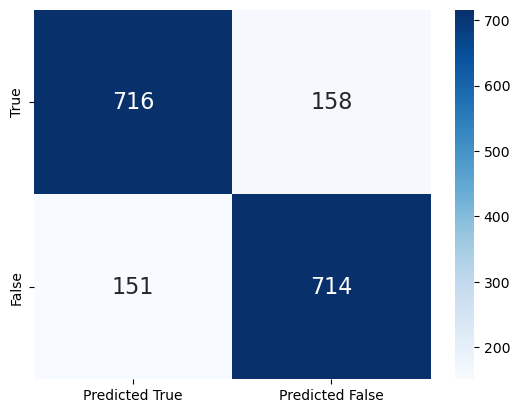

In [35]:
train_pool = Pool(X_val, y_val)
confusion_matrix = get_confusion_matrix(model, train_pool)

df_cm = pd.DataFrame(confusion_matrix, index=["True", "False"], columns=["Predicted True", "Predicted False"])

ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt='g')

plt.xticks(rotation=0)
plt.show()

As you can see our model doesn't have a strong preference for False Positives nor False Negatives but in our case it doesn't really matter.

### F1 score
We can calculate some metrics from the confusion matrix, such as precision, recall, and F1 score. F1 score is a harmonic mean of precision and recall. It measures how well the model can balance the trade-off between precision and recall.

In [36]:
precision = precision_score(y_val, model.predict(X_val))
recall = recall_score(y_val, model.predict(X_val))
f1 = f1_score(y_val, model.predict(X_val))

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")

Precision: 0.8188073394495413
Recall: 0.8254335260115607
F1 score: 0.8221070811744386


We can see that our model has a high precision, recall, and f1 score on the validation set, which means it can achieve a good balance between accuracy and sensitivity.

## SHAP values
**SHAP (SHapley Additive exPlanations)** values are a way of explaining the predictions of a machine learning model. They measure how much each feature contributes to the prediction, either positively or negatively.

In [37]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

We can see that the most important features for our model are `CabNumber`, `CabSide`, `RoomNumber`, `VRDeck`, and `CabinLetter`. These features have the highest influence on the prediction, either increasing or decreasing the probability of being transported.

# Submission
***
**Now we can apply every transformation on a test dataset step by step like we did on a training set.**

In [38]:
# Load test dataset
X_test = pd.read_csv('../input/spaceship-titanic/test.csv', index_col='PassengerId')

# Surname
X_test['Surname'] = X_test.loc[X_test['Name'].notnull(), 'Name'].apply(lambda x: x.split()[1])

# Room number
X_test['RoomNumber'] = X_test.index.str.split('_').str[0].astype(int)

# Fill missing values related with room number
for col in room_related_columns:
    room_to_col = X_test[['RoomNumber', col]].dropna().groupby('RoomNumber')[col].apply(lambda x: x.mode()[0])
    X_test[col] = X_test.apply(lambda row: room_to_col[row['RoomNumber']] if pd.isna(row[col]) and row['RoomNumber'] in room_to_col.index else row[col], axis=1)
    X_test[col] = X_test.groupby('RoomNumber')[col].ffill().bfill()
    
# Total spent
X_test['TotalSpent'] = X_test[expense_columns].sum(axis=1)
X_test.loc[X_test['TotalSpent'] == 0, expense_columns] = 0

# Split Cabin
X_test[['CabLetter', 'CabNumber', 'CabSide']] = X_test['Cabin'].str.split('/', expand=True)
X_test['CabNumber'] = pd.to_numeric(X_test['CabNumber'])

# Cryosleep
X_test.loc[X_test['CryoSleep']==True, ['TotalSpent'] + expense_columns] = 0
X_test.loc[X_test['CryoSleep'].isnull() & X_test['TotalSpent'] > 0, 'CryoSleep'] = False
X_test.loc[X_test['CryoSleep'].isnull() & X_test['TotalSpent'] == 0, 'CryoSleep'] = True

# Drop columns
X_test.drop(columns=['Cabin', 'Name'], inplace=True)

# Pipeline
X_test = column_transformer.transform(X_test)

In [39]:
sample_submission = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')
sample_submission['Transported'] = model.predict(X_test).astype(bool)
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)

# Thank You! 🚀🌟

Thank you for joining me on this exciting journey aboard the Spaceship Titanic!

I hope you had a blast exploring the dataset and building machine learning models that predict the survival outcome of each passenger. I hope you learned something new and had fun along the way.

If you have any questions or feedback, please feel free to reach out to me. Thank you again for your time and effort. Safe travels! 🛸👽